In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.interpolate import griddata
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import datetime
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, TensorDataset, DataLoader

from einops import rearrange

#PyTorch random number generator
torch.manual_seed(3407)
torch.cuda.manual_seed(3407)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
print(device)

cuda


In [2]:
bc_fine = np.zeros(((45, 168, 4)))

for i in range (45):
    df1 = pd.read_csv('C:/Users/59713/BC2MAP/inputs/case_{}.csv'.format(i+1))
    data1 = df1.values
    bc_fine[i, :, :] = data1

In [3]:
D_3d_fine = np.zeros(((45, 576, 384)))

for i in range (45):
    df2 = pd.read_csv('C:/Users/59713/BC2MAP/Saved data/fine_{}.csv'.format(i))
    data2 = df2.values
    D_3d_fine[i, :, :] = np.reshape(data2[:, 5], (576, 384))

In [4]:
E_3d_fine = np.zeros((576, 384))
X_3d_fine = np.zeros((576, 384))
Y_3d_fine = np.zeros((576, 384))
S_3d_fine = np.zeros((576, 384))
map4all = np.zeros((576, 384))

df3 = pd.read_csv('C:/Users/59713/BC2MAP/Saved data/fine_45.csv')
data3 = df3.values
X_3d_fine[:, :] = np.reshape(data3[:, 0], (576, 384))
Y_3d_fine[:, :] = np.reshape(data3[:, 1], (576, 384))
E_3d_fine[:, :] = np.reshape(data3[:, 3], (576, 384))
map4all[:, :] = np.reshape(data3[:, 5], (576, 384))

In [5]:
dzdx = np.zeros((576, 384))
dzdy = np.zeros((576, 384))

# calculate internal cell slope
for i in range (1, S_3d_fine.shape[0]-1):
    for j in range (1, S_3d_fine.shape[1]-1):
        dzdx[i, j] = ((E_3d_fine[i+1, j-1]+2*E_3d_fine[i+1, j]+E_3d_fine[i+1, j+1]) - (E_3d_fine[i-1, j-1]+E_3d_fine[i-1, j]+2*E_3d_fine[i-1, j+1]))/(8*(X_3d_fine[i+1, j]-X_3d_fine[i-1, j]))
        dzdy[i, j] = ((E_3d_fine[i-1, j+1]+2*E_3d_fine[i, j+1]+E_3d_fine[i+1, j+1]) - (E_3d_fine[i-1, j-1]+E_3d_fine[i, j-1]+2*E_3d_fine[i+1, j-1]))/(8*(Y_3d_fine[i, j+1]-Y_3d_fine[i, j-1]))
        S_3d_fine[i, j] = np.arctan(np.sqrt((dzdx[i, j])**2+(dzdy[i, j])**2))
        
# take care of the most oustside layer
S_3d_fine[0, :] = S_3d_fine[1, :]
S_3d_fine[-1, :] = S_3d_fine[-2, :]
S_3d_fine[:, 0] = S_3d_fine[:, 1]
S_3d_fine[:, -1] = S_3d_fine[:, -2]

### make a 3D info

In [6]:
all_data_X = bc_fine
all_data_Y = D_3d_fine

In [7]:
print(all_data_X.shape, all_data_Y.shape)

(45, 168, 4) (45, 576, 384)


In [8]:
# split into train and test
train_X, test_X = all_data_X[:-5, :], all_data_X[-5:, :]
train_y, test_y = all_data_Y[:-5, :, :], all_data_Y[-5:, :, :]

In [9]:
batch_size = 1

train_features = torch.Tensor(train_X).to(device)
train_targets = torch.Tensor(train_y).to(device)
test_features = torch.Tensor(test_X).to(device)
test_targets = torch.Tensor(test_y).to(device)

train = TensorDataset(train_features, train_targets)
test = TensorDataset(test_features, test_targets)

train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader_one = DataLoader(test, batch_size=1, shuffle=False, drop_last=True)

In [10]:
sup_feat = np.zeros(((batch_size, 3, 576, 384)))

# first channel is mapforall
sup_feat[:, 0, :, :] = map4all
# second channel is elevation
sup_feat[:, 1, :, :] = E_3d_fine
# third channel is slope
sup_feat[:, 2, :, :] = S_3d_fine
# fourth channel left for bc info after SA


In [11]:
class Self_Attention(nn.Module):
    def __init__(self):
        super(Self_Attention, self).__init__()
        
        self.embed_dim = 864
        self.num_heads = 1
        self.head_dim = self.embed_dim // self.num_heads
        
        self.value = nn.Linear(self.embed_dim, self.embed_dim)
        self.key = nn.Linear(self.embed_dim, self.embed_dim)
        self.query = nn.Linear(self.embed_dim, self.embed_dim)
                    
    def forward(self, x):
        queries = self.query(x)
        keys = self.key(x)
        values = self.value(x)
        
        batch_size, seq_len, embed_dim = x.size()
        # Reshape query, key, and value to split into multiple heads
        queries = queries.view(batch_size, seq_len, self.num_heads, self.head_dim)
        keys = keys.view(batch_size, seq_len, self.num_heads, self.head_dim)
        values = values.view(batch_size, seq_len, self.num_heads, self.head_dim)
        
        # Transpose to prepare for scaled dot-product attention
        queries = queries.transpose(1, 2)  # (batch_size, num_heads, seq_len, head_dim)
        keys = keys.transpose(1, 2)  # (batch_size, num_heads, seq_len, head_dim)
        values = values.transpose(1, 2)  # (batch_size, num_heads, seq_len, head_dim)
        
        # Apply softmax to get attention probabilities
        attention_scores = torch.matmul(queries, keys.transpose(-2, -1)) / (self.head_dim**0.5)
        attention_probs = F.softmax(attention_scores, dim=-1)
        
        # Compute the weighted sum of values
        x = torch.matmul(attention_probs, values)
        
        # Reshape and concatenate heads
        x = x.transpose(1, 2)
        
        out = x.reshape(x.size(0), seq_len, embed_dim)
        
        return out

In [12]:
class BC2Map(nn.Module):
    def __init__(self, input_size, output_size, background_map, batch_size):
        super(BC2Map, self).__init__()
        
        self.background_map = torch.Tensor(background_map).to(device)
        
        self.input_size = input_size
        self.hidden_dim = output_size
        batch_size = batch_size
                
        self.fc1 = nn.Linear(input_size*3, self.hidden_dim)
        self.fc2 = nn.Linear(input_size, self.hidden_dim)
        
        self.self_attention = Self_Attention().to(device)
        
        self.L1 = nn.Linear(864, 4096)
        self.L2 = nn.Linear(4096, 864)
        
        self.pos_embedding = nn.Parameter(data=torch.randn(1, 2, 576, 384)).to(device)
        
        ##-----------end of embedding ---------##
        ##-----------start of Unet ---------##
        
        self.conv1 = nn.Conv2d(in_channels=5, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.conv7 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.conv8 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.conv9 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, stride=1, padding=1)
        self.conv10 = nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, stride=1, padding=1)
        
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.conv_transpose0 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=2, stride=2, padding=0)
        self.conv_transpose1 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=2, stride=2, padding=0)
        self.conv_transpose2 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2, padding=0)
        self.conv_transpose3 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2, padding=0)
        self.conv_transpose4 = nn.ConvTranspose2d(in_channels=64, out_channels=1, kernel_size=3, stride=1, padding=1)
        
    def forward(self, x):
        # change dimension, maybe it's better to use embedding
        x = x.transpose(1, 2)
        x1 = x[:, :3, :].reshape(x.size(0), 1, -1)
        x1 = self.relu(self.fc1(x1))
        x2 = x[:, 3:, :]
        x2 = self.relu(self.fc2(x2))
        
        x = torch.cat((x1, x2), dim=1)
        x = rearrange(x, 'b c (h w) -> b c h w', h=576)
        
        # add positional embeddings
        x = x + self.pos_embedding
        
        x = rearrange(x, 'b c (h1 h) (w1 w) -> b (c h1 w1) (h w)', h1=16, w1=16)
        
        # Self-Attention #1
        x = self.self_attention(x)
        x = self.L2(self.relu(self.L1(x))) + x
        x = self.relu(x)
        
        # Self-Attention #2
        x = self.self_attention(x)
        x = self.L2(self.relu(self.L1(x))) + x
        x = self.relu(x)
        
        # Self-Attention #3
        x = self.self_attention(x)
        x = self.L2(self.relu(self.L1(x))) + x
        x = self.relu(x)
        
        # Self-Attention #4
        x = self.self_attention(x)
        
        # Concat the full feature map
        x = rearrange(x, 'b (c h1 w1) (h w) -> b c (h1 h) (w1 w)', h1=16, w1=16, c=2, h=36, w=24)
        x = torch.cat((x, self.background_map), dim=1)
        
        # initial conv: 1->64
        x = self.relu(self.conv1(x))
        
        # 1st resblock: 64->64
        identity = x
        x = self.conv2(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = x + identity
        x = self.relu(x)
        x = self.maxpool(x)
        
        # 2nd resblock: 64->128
        identity2 = x
        x = self.conv3(x)
        x = self.relu(x)
        x = self.conv4(x)
        identity2 = self.conv3(identity2)
        x = x + identity2
        x = self.relu(x)
        x = self.maxpool(x)
        
        # 3rd resblock: 128->256
        identity3 = x
        x = self.conv5(x)
        x = self.relu(x)
        x = self.conv6(x)
        identity3 = self.conv5(identity3)
        x = x + identity3
        x = self.relu(x)
        x = self.maxpool(x)
        
        # 4th resblock: 256->512
        identity4 = x
        x = self.conv7(x)
        x = self.relu(x)
        x = self.conv8(x)
        identity4 = self.conv7(identity4)
        x = x + identity4
        x = self.relu(x)
        x = self.maxpool(x)
        
        # 5th resblock: 512->1024
        identity5 = x
        x = self.conv9(x)
        x = self.relu(x)
        x = self.conv10(x)
        identity5 = self.conv9(identity5)
        x = x + identity5
        x = self.relu(x)
        
        # transpose0: 1024->512
        x = self.relu(self.conv_transpose0(x))
        identity7 = x
        x = self.conv8(x)
        x = self.relu(x)
        x = self.conv8(x)
        x = x + identity7
        x = self.relu(x)
        
        # transpose1: 512->256
        x = self.relu(self.conv_transpose1(x))
        identity8 = x
        x = self.conv6(x)
        x = self.relu(x)
        x = self.conv6(x)
        x = x + identity8
        x = self.relu(x)
        
        # transpose2: 256->128
        x = self.relu(self.conv_transpose2(x))
        identity9 = x
        x = self.conv4(x)
        x = self.relu(x)
        x = self.conv4(x)
        x = x + identity9
        
        # transpose3: 128->64
        x = self.relu(self.conv_transpose3(x))
        identity10 = x
        x = self.conv2(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = x + identity10
        x = self.relu(x)
        
        # transpose4: 64->1
        x = self.relu(self.conv_transpose4(x))
        
        out = x.reshape(x.size(0), -1)
        
        return out

In [13]:
class Optimization:
    def __init__(self, model, optimizer):
        self.model = model
        self.loss_fn = nn.MSELoss(reduction="mean")
        self.optimizer = optimizer
        self.train_losses = []
        self.val_losses = []
    
    def train_step(self, x, y):
        # Sets model to train mode
        self.model.train()

        # Makes predictions
        yhat = self.model(x)

        # Computes loss
        loss = self.loss_fn(y, yhat)

        # Computes gradients
        loss.backward()

        # Updates parameters and zeroes gradients
        self.optimizer.step()
        self.optimizer.zero_grad()

        # Returns the loss
        return loss.item()

    def train(self, train_loader, val_loader, batch_size=4, n_epochs=50):
        model_path = f'models/{self.model}_{datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")}'

        for epoch in range(1, n_epochs + 1):
            batch_losses = []
            for x_batch, y_batch in train_loader:
                x_batch = x_batch.to(device)
                y_batch = y_batch.view([batch_size, 576*384]).to(device)
                loss = self.train_step(x_batch, y_batch)
                batch_losses.append(loss)
            training_loss = np.mean(batch_losses)
            self.train_losses.append(training_loss)

            with torch.no_grad():
                batch_val_losses = []
                for x_val, y_val in val_loader:
                    x_val = x_val.to(device)
                    y_val = y_val.view([batch_size, 576*384]).to(device)
                    self.model.eval()
                    yhat = self.model(x_val).to(device)
                    val_loss = self.loss_fn(y_val, yhat).item()
                    batch_val_losses.append(val_loss)
                validation_loss = np.mean(batch_val_losses)
                self.val_losses.append(validation_loss)

            if (epoch % 5 == 0):
                print(
                    f"[{epoch}/{n_epochs}] Training loss: {training_loss:.6f}\t Validation loss: {validation_loss:.6f}"
                )
            
            if (validation_loss <= 0.004):
                break

#         torch.save(self.model.state_dict(), model_path)

    def evaluate(self, test_loader, batch_size=1):
        with torch.no_grad():
            predictions = []
            values = []
            for x_test, y_test in test_loader:
                x_test = x_test.to(device)
                y_test = y_test.view([batch_size, 576*384]).to(device)
                self.model.eval()
                yhat = self.model(x_test)
                predictions.append(yhat.cpu().detach().numpy())
                values.append(y_test.cpu().detach().numpy())

        return predictions, values

    def plot_losses(self):
        plt.plot(self.train_losses, label="Training loss")
        plt.plot(self.val_losses, label="Validation loss")
        plt.legend()
        plt.title("Losses")
        plt.show()
        plt.close()

[5/5000] Training loss: 0.413394	 Validation loss: 0.342427
[10/5000] Training loss: 0.246040	 Validation loss: 0.195863
[15/5000] Training loss: 0.109701	 Validation loss: 0.144598
[20/5000] Training loss: 0.080256	 Validation loss: 0.133794
[25/5000] Training loss: 0.068548	 Validation loss: 0.106555
[30/5000] Training loss: 0.067304	 Validation loss: 0.111285
[35/5000] Training loss: 0.064297	 Validation loss: 0.093021
[40/5000] Training loss: 0.060509	 Validation loss: 0.096157
[45/5000] Training loss: 0.065315	 Validation loss: 0.101603
[50/5000] Training loss: 0.107301	 Validation loss: 0.239059
[55/5000] Training loss: 0.075109	 Validation loss: 0.087857
[60/5000] Training loss: 0.054119	 Validation loss: 0.095715
[65/5000] Training loss: 0.077770	 Validation loss: 0.090390
[70/5000] Training loss: 0.049020	 Validation loss: 0.089936
[75/5000] Training loss: 0.046631	 Validation loss: 0.080753
[80/5000] Training loss: 0.051813	 Validation loss: 0.113060
[85/5000] Training loss: 

[670/5000] Training loss: 0.013339	 Validation loss: 0.014672
[675/5000] Training loss: 0.003370	 Validation loss: 0.013064
[680/5000] Training loss: 0.004508	 Validation loss: 0.014989
[685/5000] Training loss: 0.006220	 Validation loss: 0.012615
[690/5000] Training loss: 0.010744	 Validation loss: 0.012689
[695/5000] Training loss: 0.007255	 Validation loss: 0.021196
[700/5000] Training loss: 0.002882	 Validation loss: 0.012405
[705/5000] Training loss: 0.002463	 Validation loss: 0.010493
[710/5000] Training loss: 0.002383	 Validation loss: 0.010263
[715/5000] Training loss: 0.004348	 Validation loss: 0.024773
[720/5000] Training loss: 0.045692	 Validation loss: 0.019023
[725/5000] Training loss: 0.013622	 Validation loss: 0.013729
[730/5000] Training loss: 0.002545	 Validation loss: 0.013197
[735/5000] Training loss: 0.001825	 Validation loss: 0.013996
[740/5000] Training loss: 0.003289	 Validation loss: 0.009106
[745/5000] Training loss: 0.001569	 Validation loss: 0.009579
[750/500

[1330/5000] Training loss: 0.001082	 Validation loss: 0.008669
[1335/5000] Training loss: 0.001661	 Validation loss: 0.009101
[1340/5000] Training loss: 0.010261	 Validation loss: 0.013503
[1345/5000] Training loss: 0.014843	 Validation loss: 0.042588
[1350/5000] Training loss: 0.006259	 Validation loss: 0.013857
[1355/5000] Training loss: 0.001979	 Validation loss: 0.008630
[1360/5000] Training loss: 0.000737	 Validation loss: 0.009938
[1365/5000] Training loss: 0.001265	 Validation loss: 0.007710
[1370/5000] Training loss: 0.002579	 Validation loss: 0.007875
[1375/5000] Training loss: 0.001519	 Validation loss: 0.007143
[1380/5000] Training loss: 0.015959	 Validation loss: 0.023252
[1385/5000] Training loss: 0.036011	 Validation loss: 0.097069
[1390/5000] Training loss: 0.009960	 Validation loss: 0.019526
[1395/5000] Training loss: 0.002398	 Validation loss: 0.009507
[1400/5000] Training loss: 0.019988	 Validation loss: 0.013573
[1405/5000] Training loss: 0.008644	 Validation loss: 0

[1985/5000] Training loss: 0.003664	 Validation loss: 0.018712
[1990/5000] Training loss: 0.004791	 Validation loss: 0.014000
[1995/5000] Training loss: 0.001268	 Validation loss: 0.009616
[2000/5000] Training loss: 0.000983	 Validation loss: 0.012095
[2005/5000] Training loss: 0.000673	 Validation loss: 0.010387
[2010/5000] Training loss: 0.002259	 Validation loss: 0.009571
[2015/5000] Training loss: 0.007023	 Validation loss: 0.018928
[2020/5000] Training loss: 0.002789	 Validation loss: 0.011065
[2025/5000] Training loss: 0.007815	 Validation loss: 0.022760
[2030/5000] Training loss: 0.001302	 Validation loss: 0.016030
[2035/5000] Training loss: 0.000769	 Validation loss: 0.010457
[2040/5000] Training loss: 0.000515	 Validation loss: 0.009892
[2045/5000] Training loss: 0.000503	 Validation loss: 0.012002
[2050/5000] Training loss: 0.000583	 Validation loss: 0.009872
[2055/5000] Training loss: 0.000528	 Validation loss: 0.009026
[2060/5000] Training loss: 0.000888	 Validation loss: 0

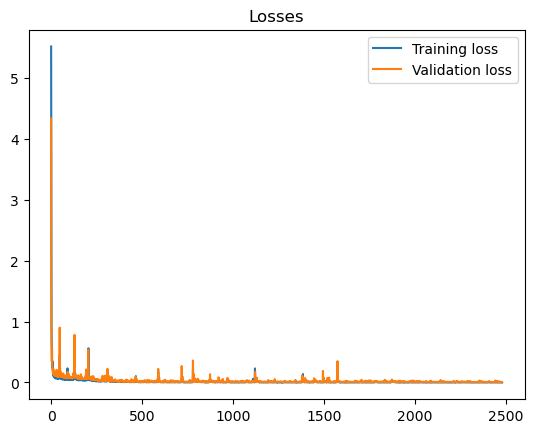

In [14]:
input_size = 672//4
output_size = 576 * 384

batch_size = batch_size
n_epochs = 5000
learning_rate = 1e-4
weight_decay = learning_rate/n_epochs

model = BC2Map(input_size, output_size, background_map=sup_feat, batch_size=batch_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

opt = Optimization(model=model, optimizer=optimizer)
opt.train(train_loader, test_loader, batch_size=batch_size, n_epochs=n_epochs)
opt.plot_losses()

In [15]:
predictions, values = opt.evaluate(test_loader_one, batch_size=1)

preds = np.array(predictions)
vals = np.array(values)

preds = np.reshape(preds, (5, 576, 384))
vals = np.reshape(vals, (5, 576, 384))

print(preds.shape, vals.shape)

(5, 576, 384) (5, 576, 384)


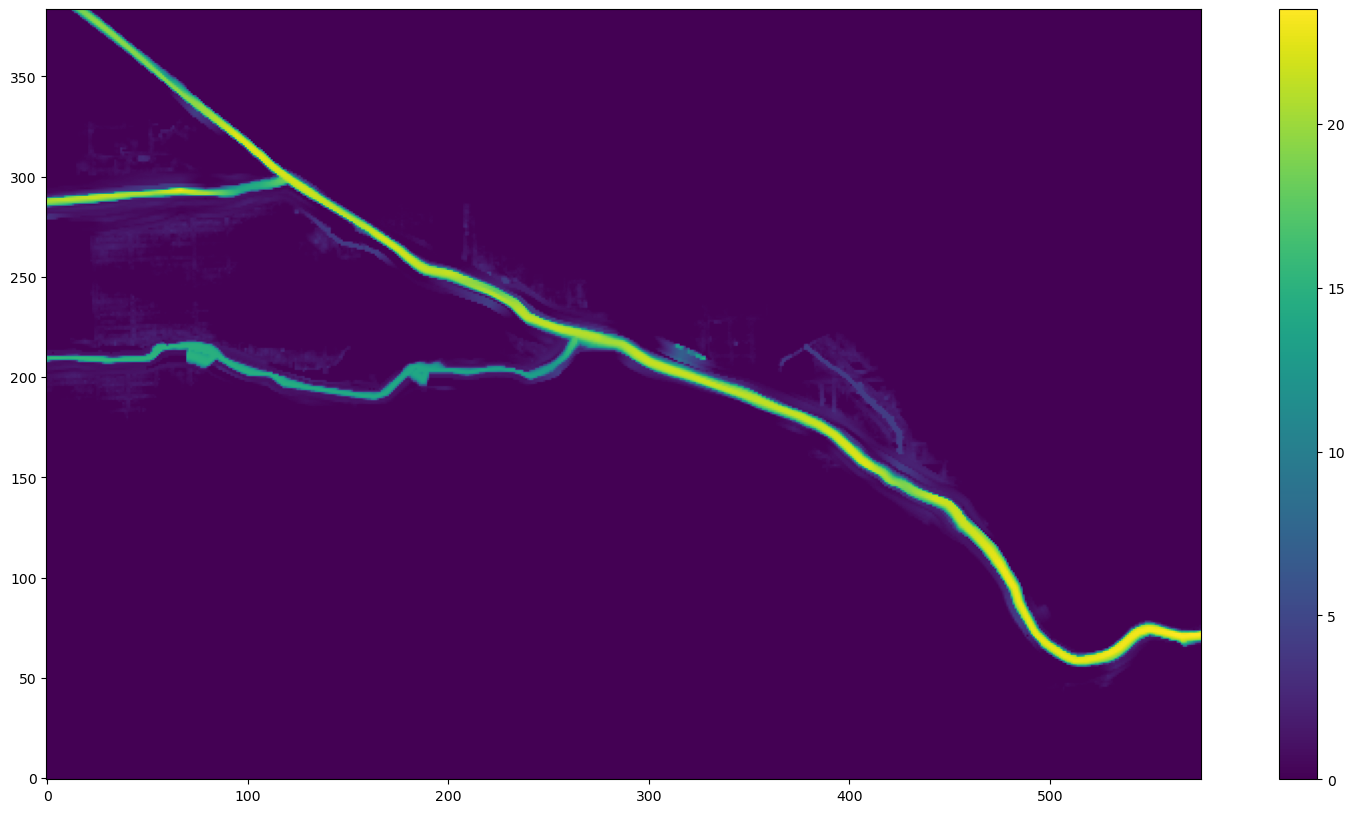

In [16]:
plt.rcParams['figure.figsize'] = [20, 10]

plt.imshow(preds[0, :, :].transpose(), cmap='viridis', origin='lower')
plt.colorbar()  # Add a colorbar for reference
plt.show()
plt.close()

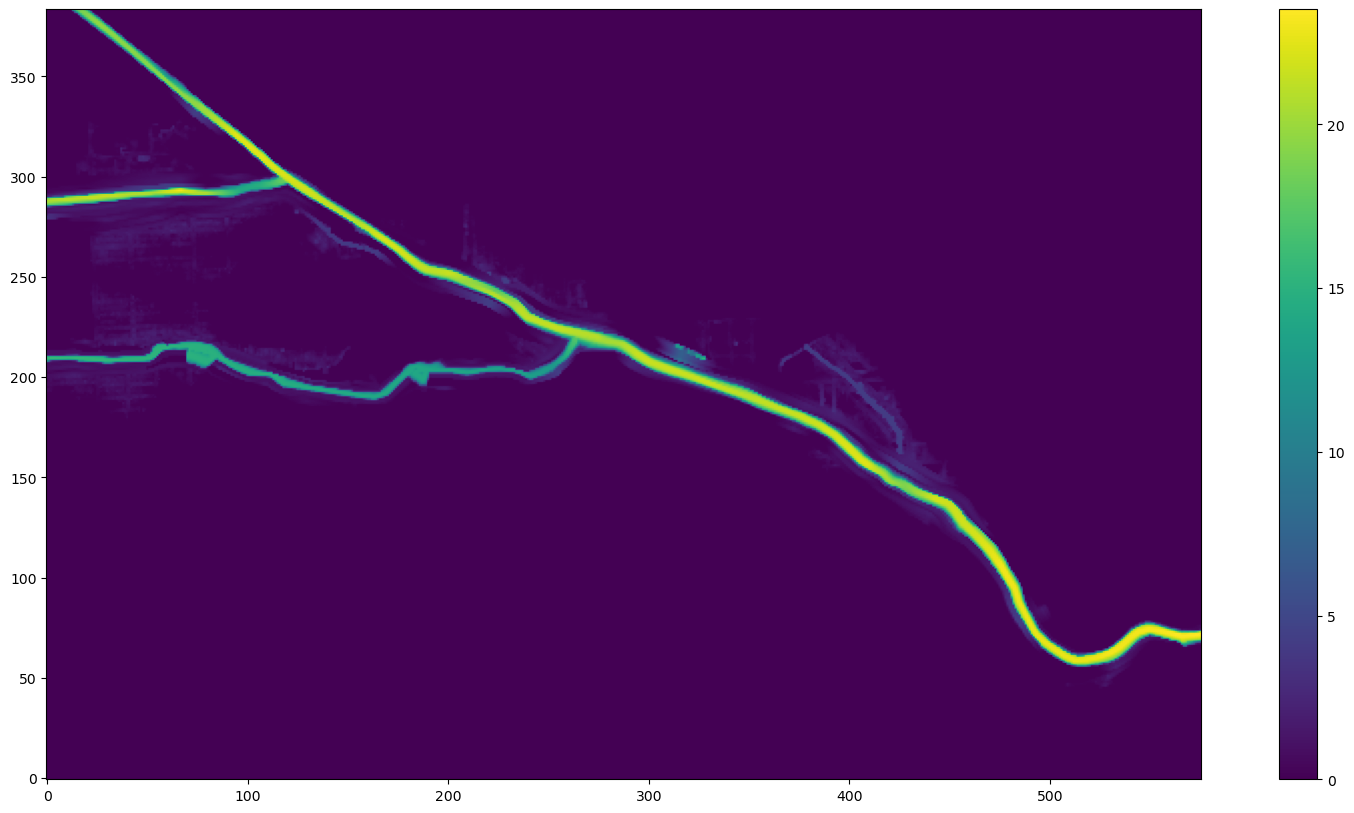

In [17]:
plt.imshow(vals[0, :, :].transpose(), cmap='viridis', origin='lower')
plt.colorbar()  # Add a colorbar for reference
plt.show()
plt.close()

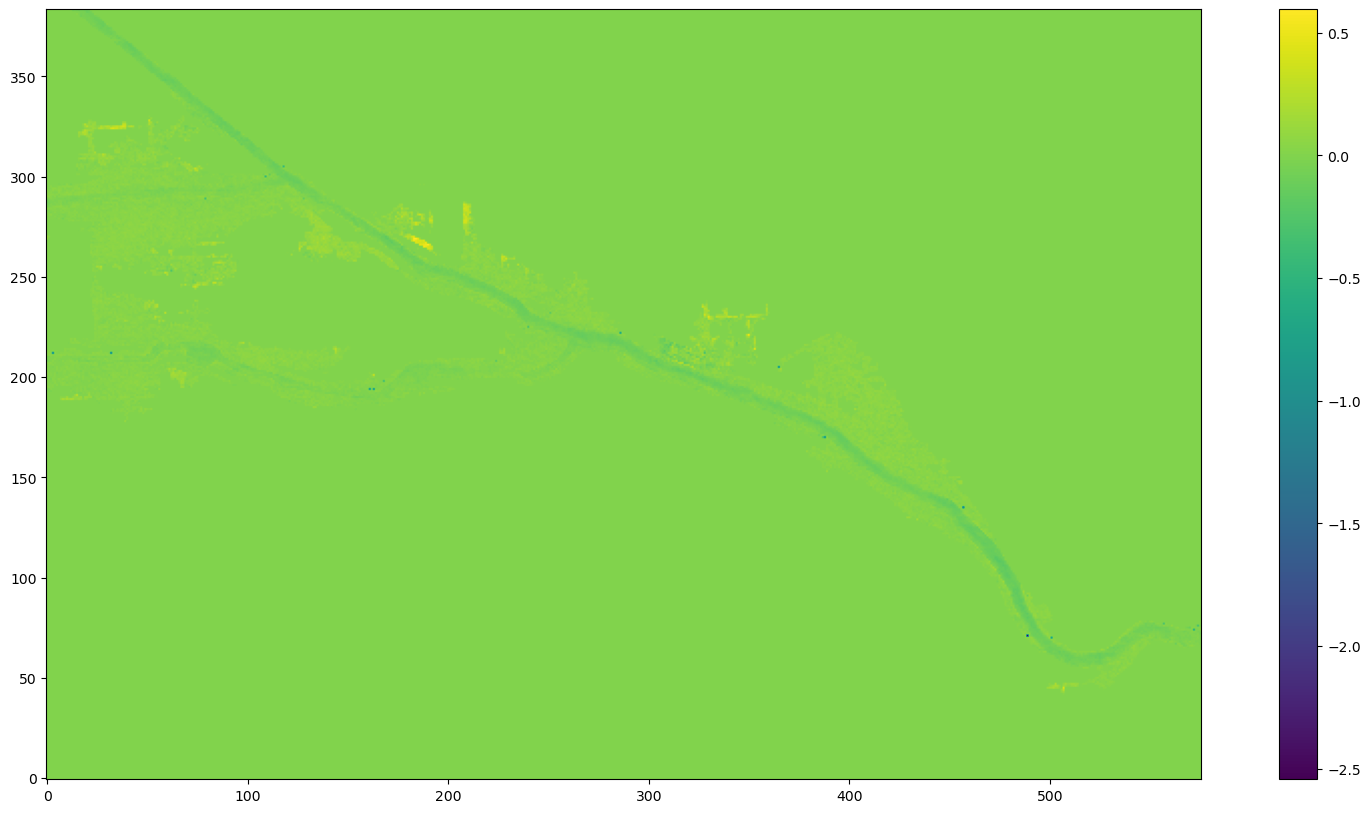

In [18]:
plt.imshow(preds[0, :, :].transpose() - vals[0, :, :].transpose(), cmap='viridis', origin='lower')
plt.colorbar()  # Add a colorbar for reference
plt.show()
plt.close()

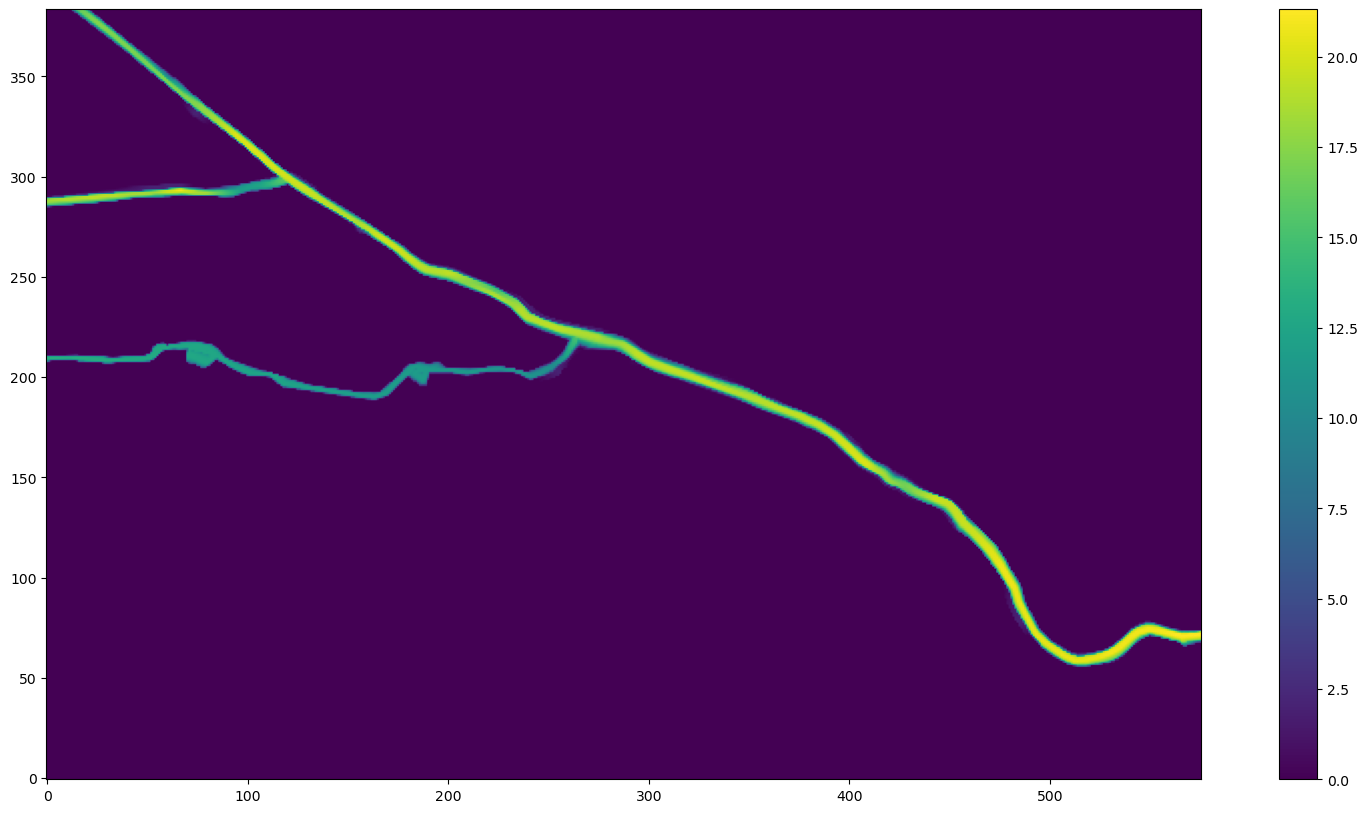

In [19]:
plt.rcParams['figure.figsize'] = [20, 10]

plt.imshow(preds[1, :, :].transpose(), cmap='viridis', origin='lower')
plt.colorbar()  # Add a colorbar for reference
plt.show()
plt.close()

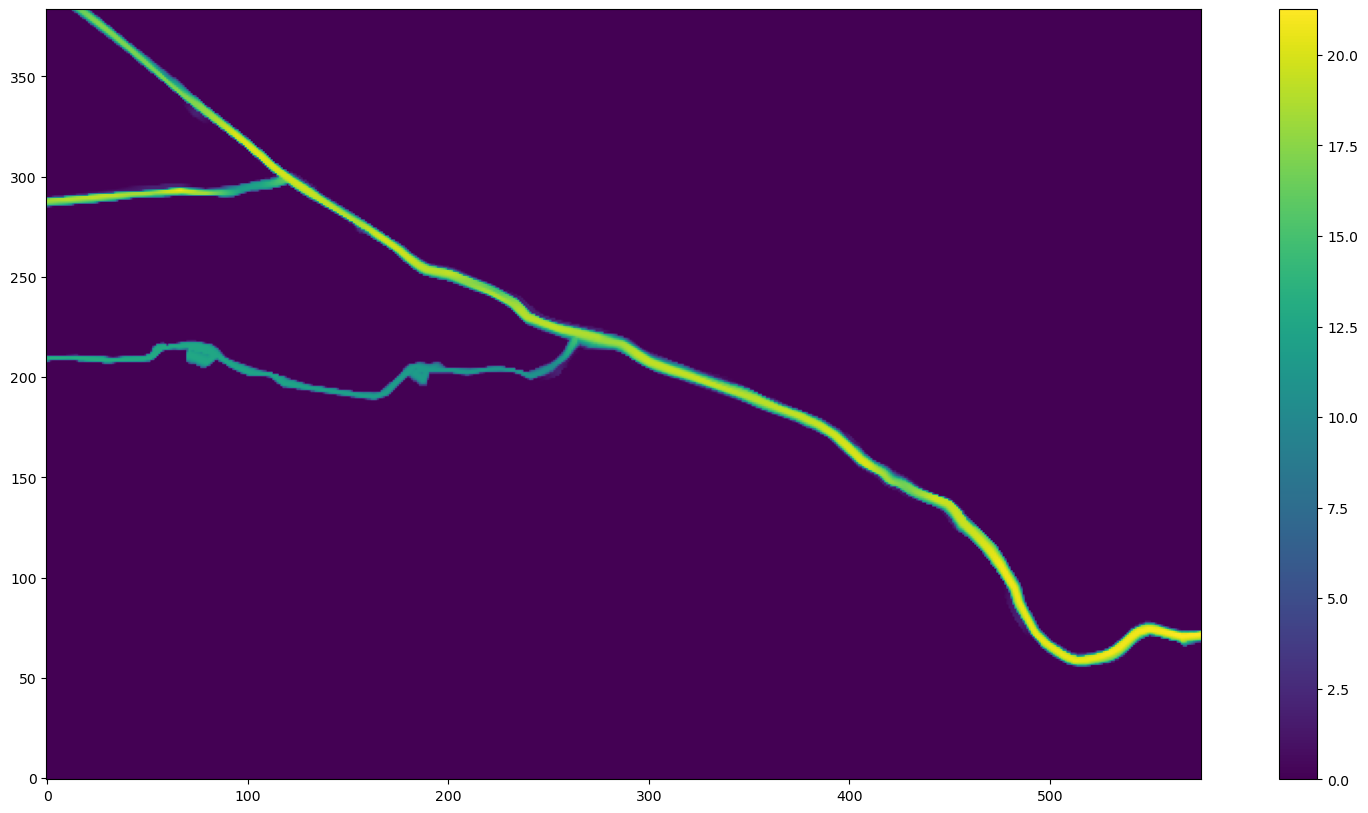

In [20]:
plt.rcParams['figure.figsize'] = [20, 10]

plt.imshow(vals[1, :, :].transpose(), cmap='viridis', origin='lower')
plt.colorbar()  # Add a colorbar for reference
plt.show()
plt.close()

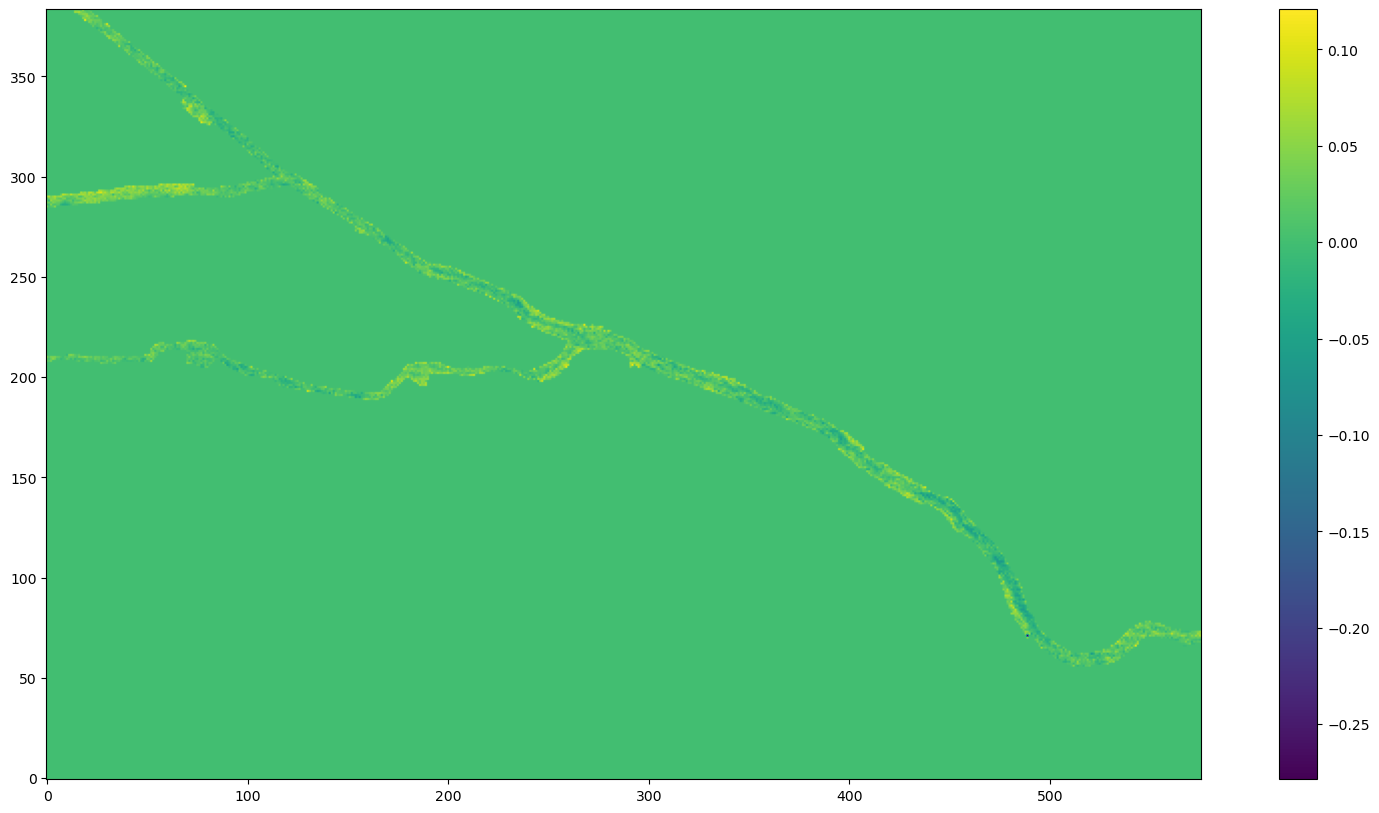

In [21]:
plt.imshow(preds[1, :, :].transpose() - vals[1, :, :].transpose(), cmap='viridis', origin='lower')
plt.colorbar()  # Add a colorbar for reference
plt.show()
plt.close()

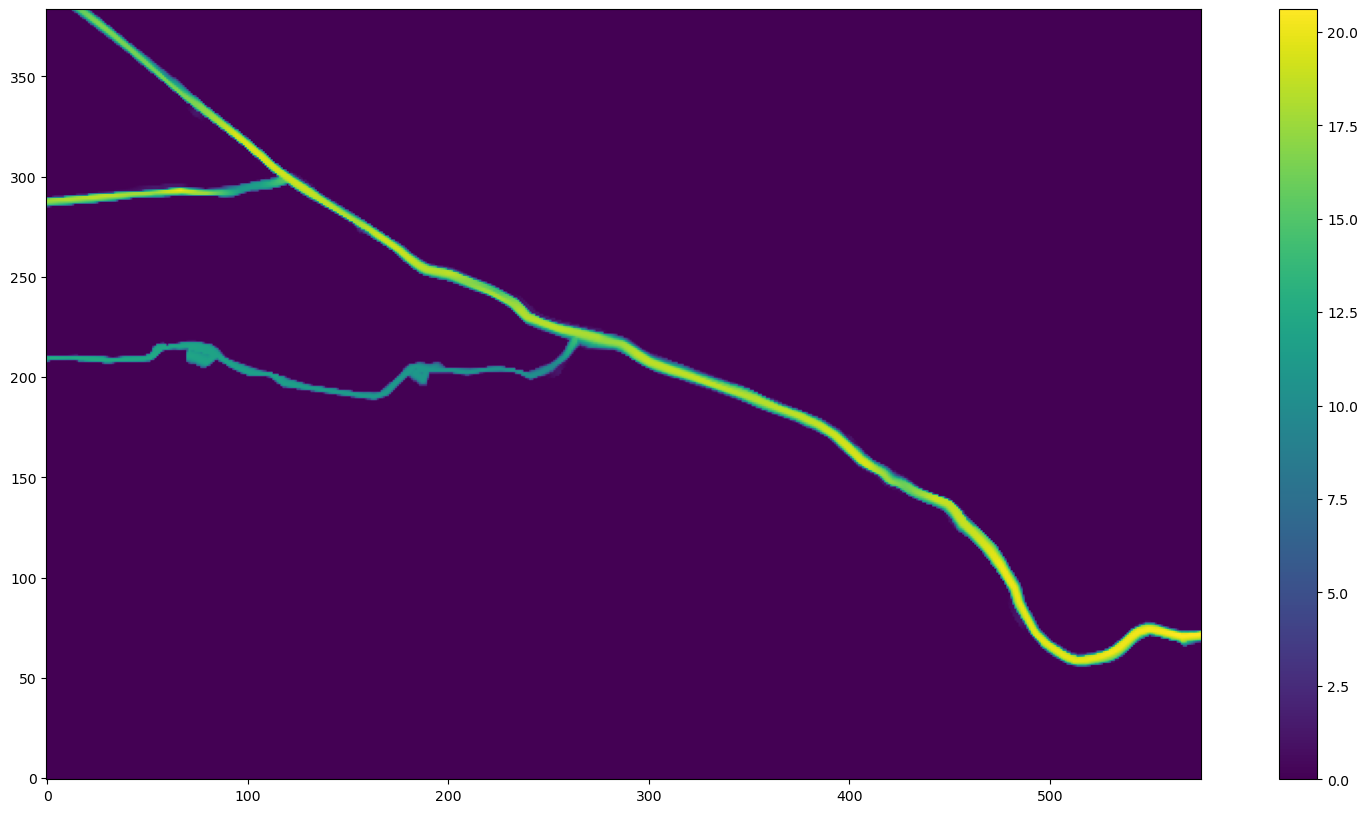

In [22]:
plt.rcParams['figure.figsize'] = [20, 10]

plt.imshow(preds[2, :, :].transpose(), cmap='viridis', origin='lower')
plt.colorbar()  # Add a colorbar for reference
plt.show()
plt.close()

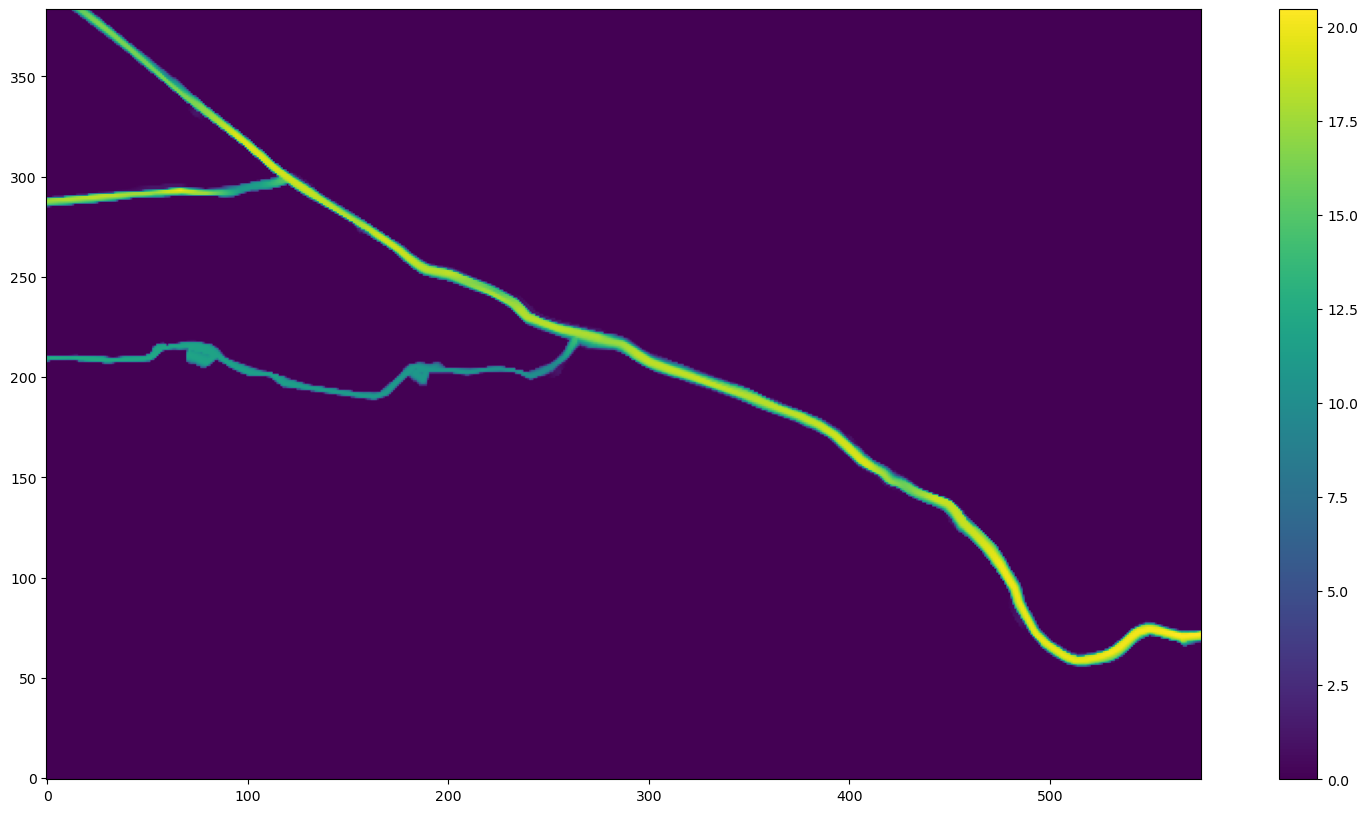

In [23]:
plt.rcParams['figure.figsize'] = [20, 10]

plt.imshow(vals[2, :, :].transpose(), cmap='viridis', origin='lower')
plt.colorbar()  # Add a colorbar for reference
plt.show()
plt.close()

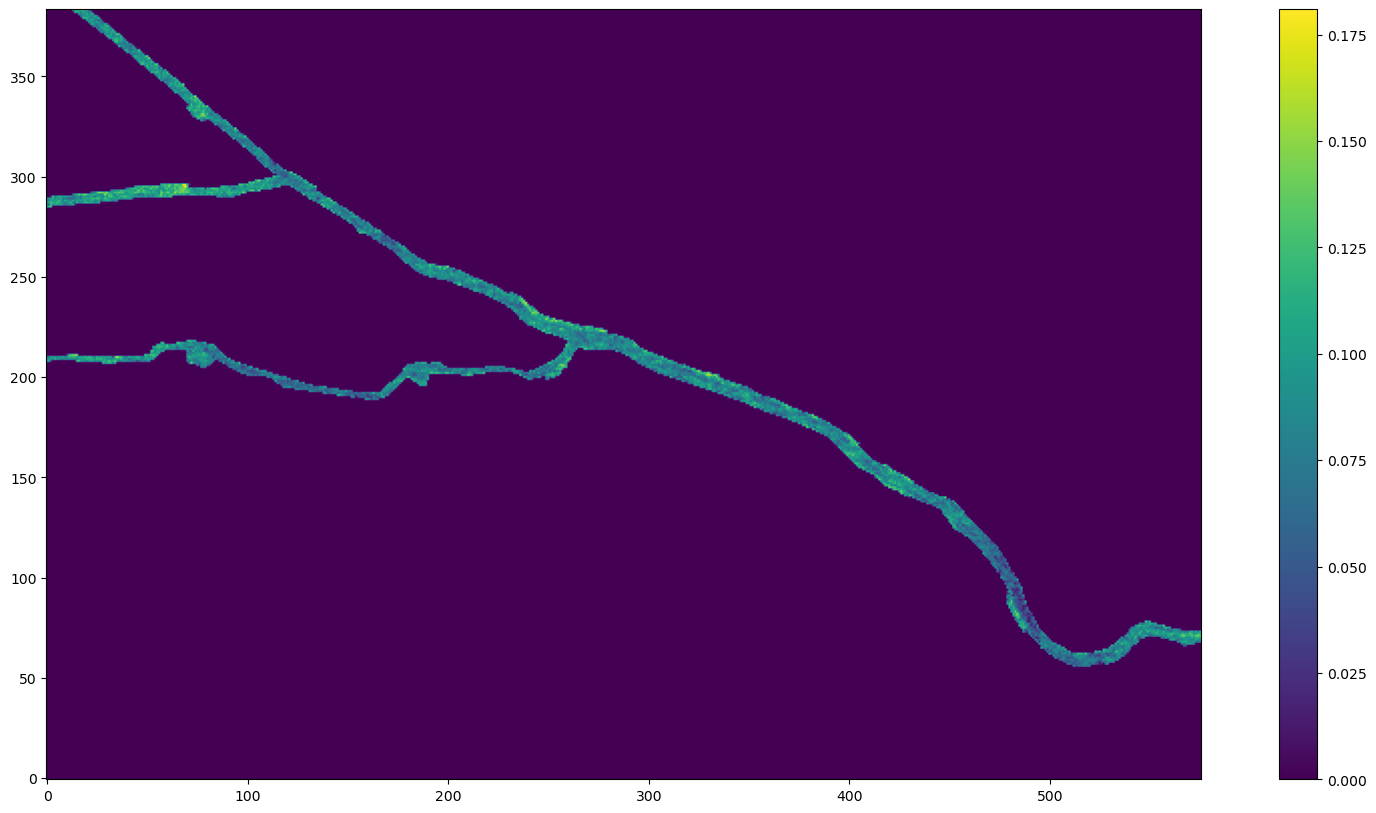

In [24]:
plt.imshow(preds[2, :, :].transpose() - vals[2, :, :].transpose(), cmap='viridis', origin='lower')
plt.colorbar()  # Add a colorbar for reference
plt.show()
plt.close()

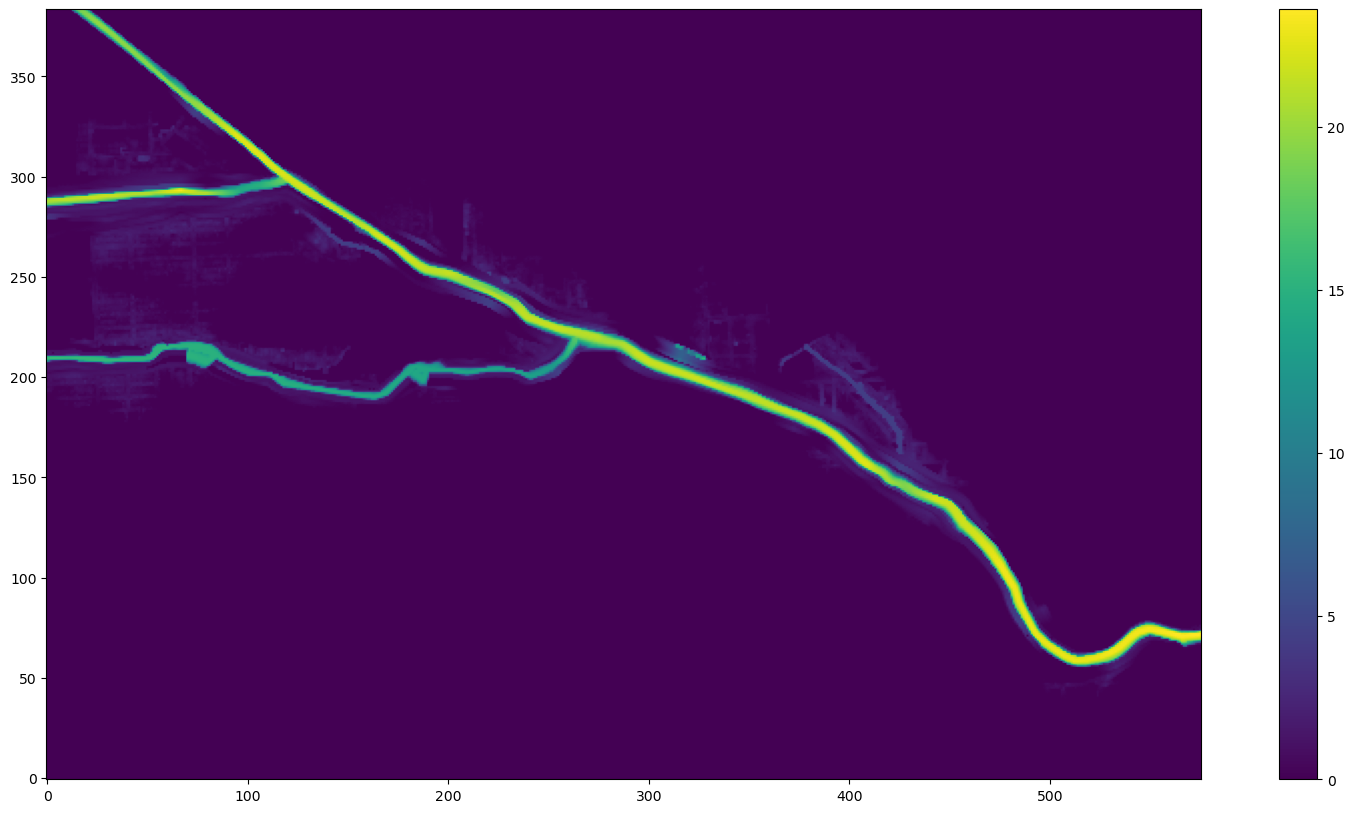

In [25]:
plt.rcParams['figure.figsize'] = [20, 10]

plt.imshow(preds[3, :, :].transpose(), cmap='viridis', origin='lower')
plt.colorbar()  # Add a colorbar for reference
plt.show()
plt.close()

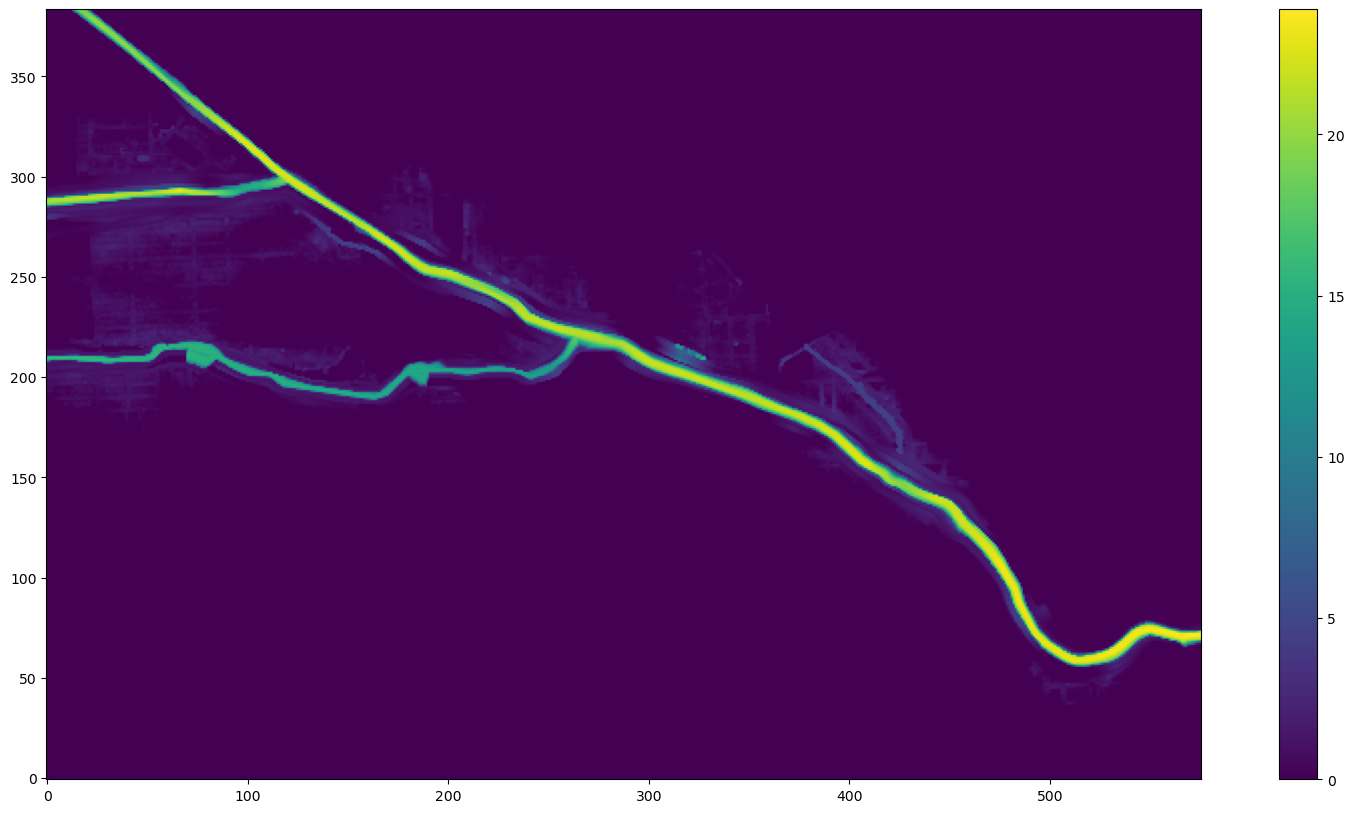

In [26]:
plt.rcParams['figure.figsize'] = [20, 10]

plt.imshow(vals[3, :, :].transpose(), cmap='viridis', origin='lower')
plt.colorbar()  # Add a colorbar for reference
plt.show()
plt.close()

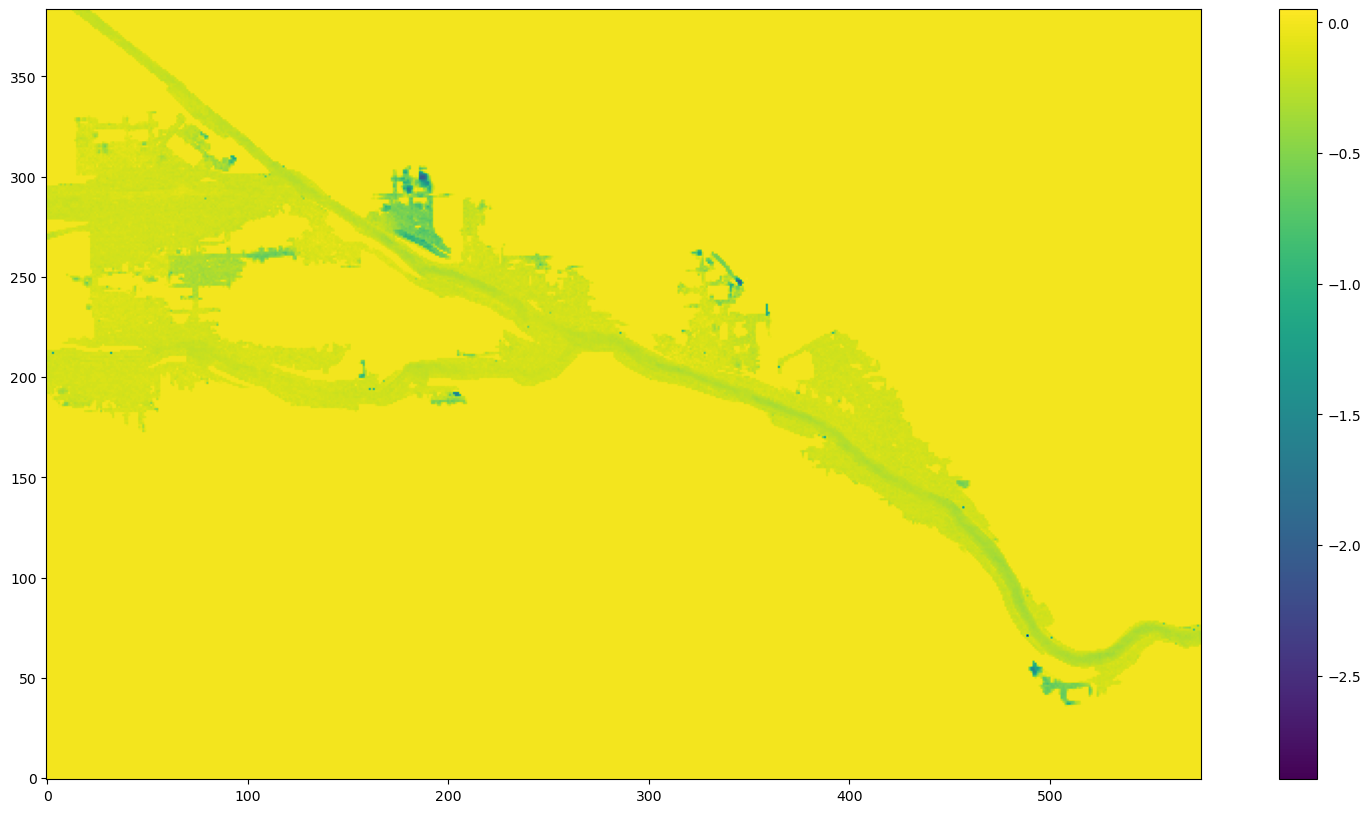

In [27]:
plt.imshow(preds[3, :, :].transpose() - vals[3, :, :].transpose(), cmap='viridis', origin='lower')
plt.colorbar()  # Add a colorbar for reference
plt.show()
plt.close()

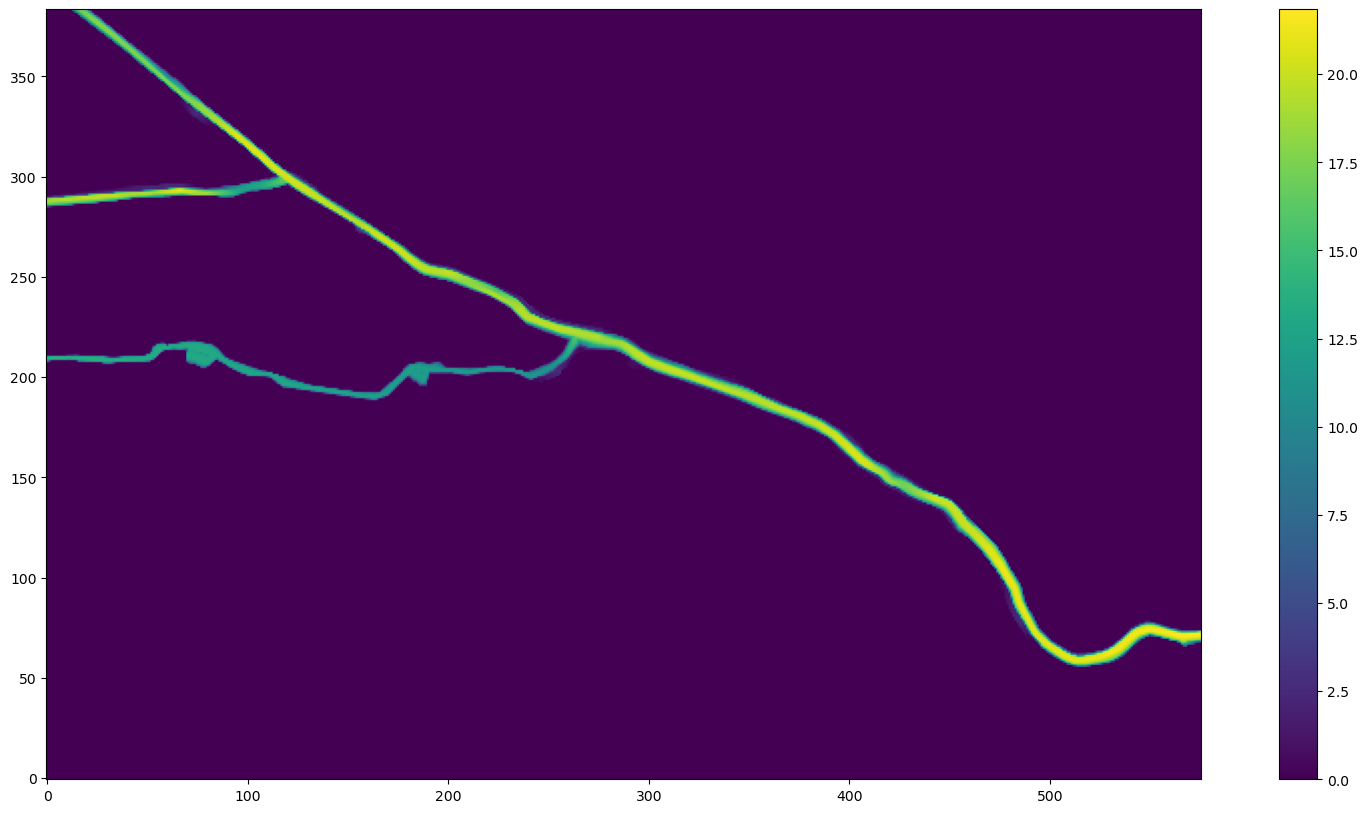

In [28]:
plt.rcParams['figure.figsize'] = [20, 10]

plt.imshow(preds[4, :, :].transpose(), cmap='viridis', origin='lower')
plt.colorbar()  # Add a colorbar for reference
plt.show()
plt.close()

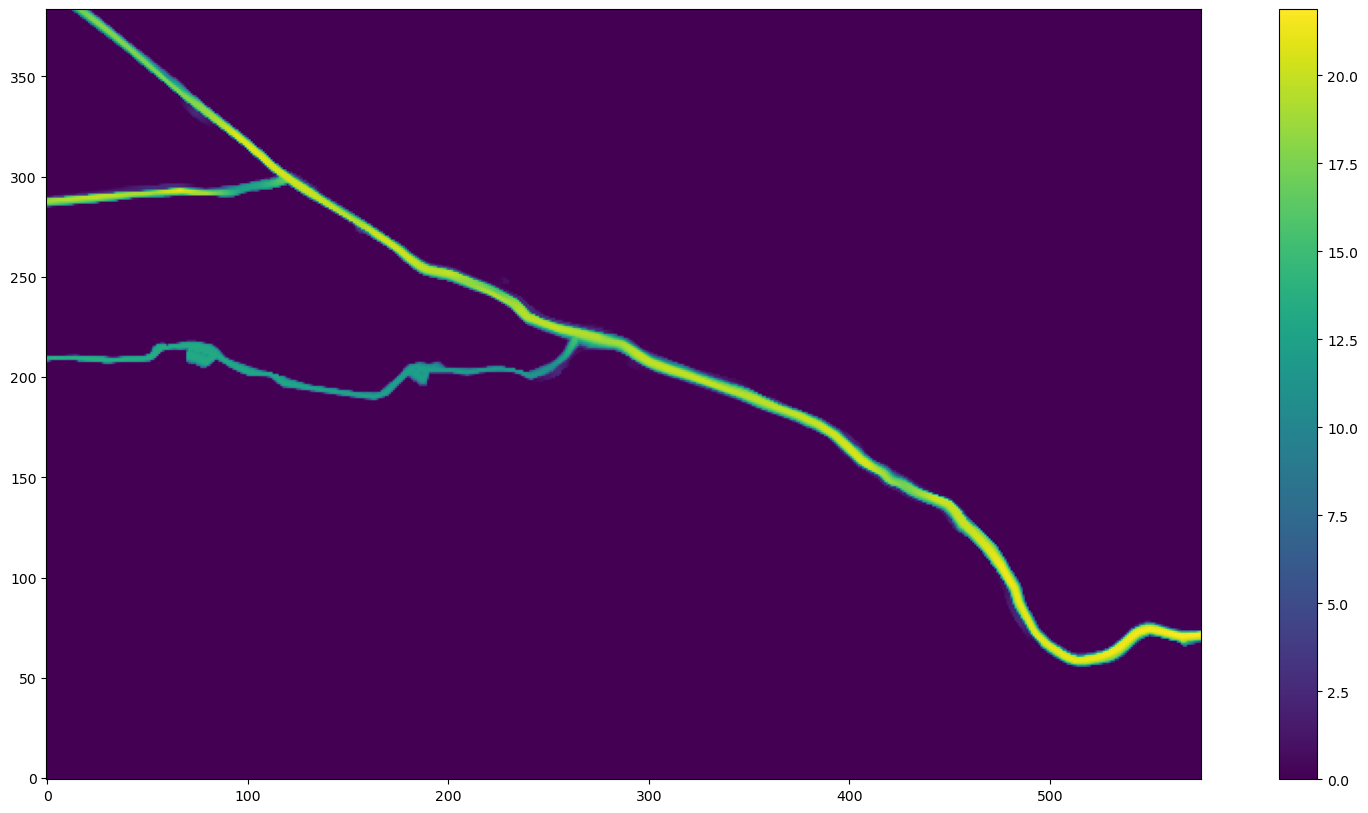

In [29]:
plt.rcParams['figure.figsize'] = [20, 10]

plt.imshow(vals[4, :, :].transpose(), cmap='viridis', origin='lower')
plt.colorbar()  # Add a colorbar for reference
plt.show()
plt.close()

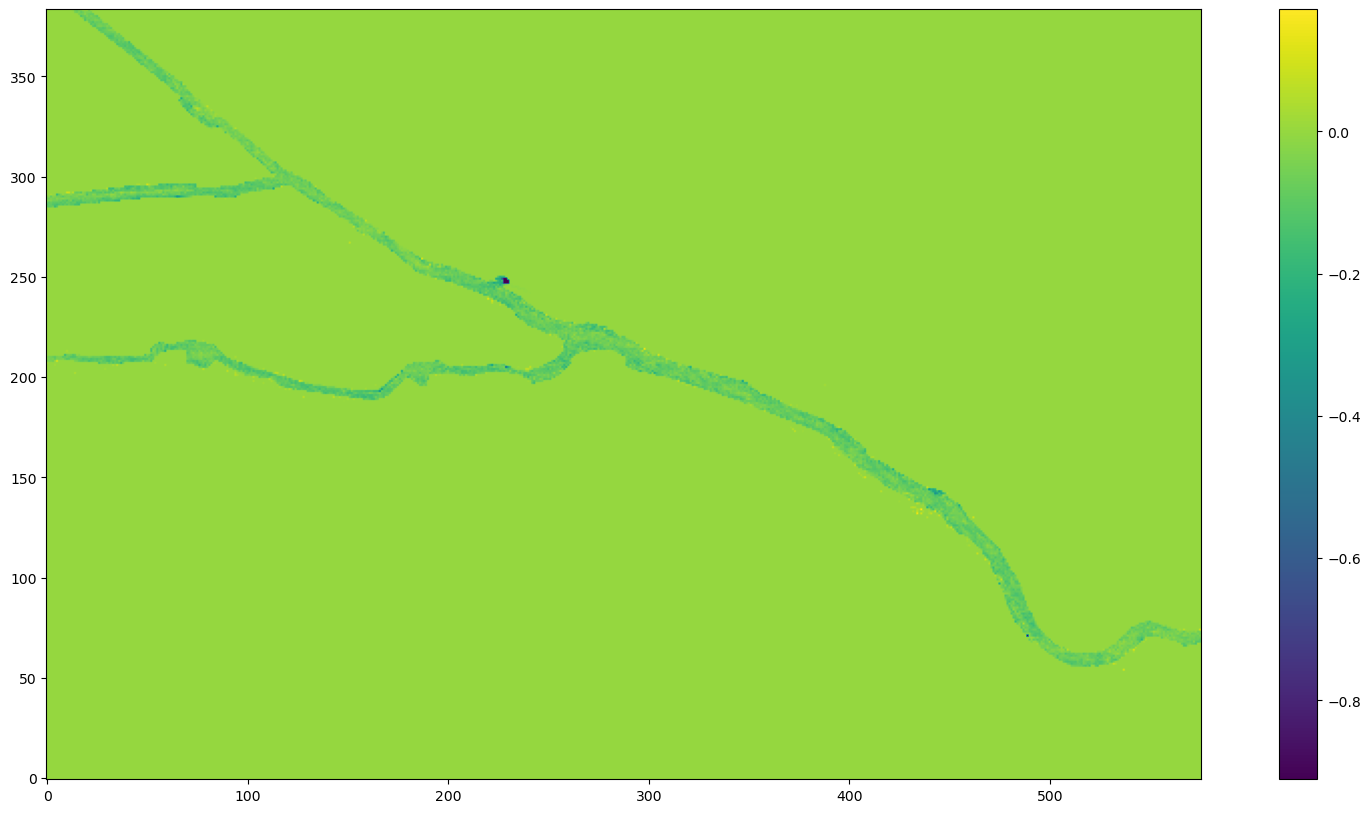

In [30]:
plt.imshow(preds[4, :, :].transpose() - vals[4, :, :].transpose(), cmap='viridis', origin='lower')
plt.colorbar()  # Add a colorbar for reference
plt.show()
plt.close()

In [31]:
torch.save(model.state_dict(), 'Saved models/0SA4+Unet1024')

In [32]:
savfig_p = np.reshape(preds, (5, 576*384))
savfig_t = np.reshape(vals, (5, 576*384))

savfig_p = pd.DataFrame(savfig_p)
savfig_t = pd.DataFrame(savfig_t)

savfig_p.to_csv('CSVs/0SA4+Unet1024.csv', index=False)

In [33]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def calculate_metrics(df1, df2):
    return {'mae' : mean_absolute_error(df1, df2),
            'rmse' : mean_squared_error(df1, df2) ** 0.5,
            'r2' : r2_score(df1, df2)}

In [34]:
result_metrics = calculate_metrics(savfig_t, savfig_p)
result_metrics

{'mae': 0.007173355, 'rmse': 0.039741370379714785, 'r2': 0.7350850783680215}